# Implementing Character level RNN for Text Classification

# Get Data

In [27]:
!nvidia-smi

Sun May  3 09:21:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

A character-level RNN reads words as a series of characters - outputting a prediction and “hidden state” at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we’ll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling:

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import glob
import os
import torch
import torch.nn as nn

In [29]:
! wget https://download.pytorch.org/tutorial/data.zip

--2020-05-03 09:21:44--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.0.64, 13.224.0.31, 13.224.0.88, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.0.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  --.-KB/s    in 0.05s   

2020-05-03 09:21:44 (50.5 MB/s) - ‘data.zip.1’ saved [2882130/2882130]



In [30]:
!unzip /content/data.zip

Archive:  /content/data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Preprocessing

In [0]:
def findFiles(path): 
    return glob.glob(path)

In [32]:
print(findFiles('/content/data/names/*.txt'))

['/content/data/names/Italian.txt', '/content/data/names/Dutch.txt', '/content/data/names/French.txt', '/content/data/names/German.txt', '/content/data/names/Russian.txt', '/content/data/names/Korean.txt', '/content/data/names/Vietnamese.txt', '/content/data/names/Scottish.txt', '/content/data/names/Greek.txt', '/content/data/names/English.txt', '/content/data/names/Portuguese.txt', '/content/data/names/Spanish.txt', '/content/data/names/Arabic.txt', '/content/data/names/Chinese.txt', '/content/data/names/Japanese.txt', '/content/data/names/Polish.txt', '/content/data/names/Irish.txt', '/content/data/names/Czech.txt']


In [0]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [0]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


In [35]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [0]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


In [0]:
for filename in findFiles('/content/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    # print(category)

In [38]:
print(category_lines)

{'Italian': ['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni', 'Abatescianni', 'Abba', 'Abbadelli', 'Abbascia', 'Abbatangelo', 'Abbatantuono', 'Abbate', 'Abbatelli', 'Abbaticchio', 'Abbiati', 'Abbracciabene', 'Abbracciabeni', 'Abelli', 'Abello', 'Abrami', 'Abramo', 'Acardi', 'Accardi', 'Accardo', 'Acciai', 'Acciaio', 'Acciaioli', 'Acconci', 'Acconcio', 'Accorsi', 'Accorso', 'Accosi', 'Accursio', 'Acerbi', 'Acone', 'Aconi', 'Acqua', 'Acquafredda', 'Acquarone', 'Acquati', 'Adalardi', 'Adami', 'Adamo', 'Adamoli', 'Addario', 'Adelardi', 'Adessi', 'Adimari', 'Adriatico', 'Affini', 'Africani', 'Africano', 'Agani', 'Aggi', 'Aggio', 'Agli', 'Agnelli', 'Agnellutti', 'Agnusdei', 'Agosti', 'Agostini', 'Agresta', 'Agrioli', 'Aiello', 'Aiolfi', 'Airaldi', 'Airo', 'Aita', 'Ajello', 'Alagona', 'Alamanni', 'Albanesi', 'Albani', 'Albano', 'Alberghi', 'Alberghini', 'Alberici', 'Alberighi', 'Albero', 'Albini', 'Albricci', 'Albrici', 'Alcheri', 'Aldebrandi', 'Alderisi', 'Alduino', 'Alem

In [0]:
n_categories = len(all_categories)

Now we have category_lines, a dictionary mapping each category (language) to a list of lines (names). We also kept track of all_categories (just a list of languages) and n_categories for later reference.

In [40]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# Turning Names into Tensors



Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

In [0]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [0]:
# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


In [43]:
print(letterToTensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [44]:
print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


# Creating the Network

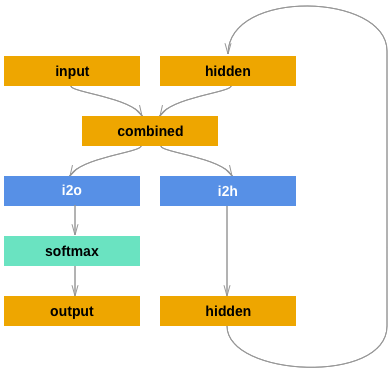

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [0]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

# Check the I/O

In [0]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

In [48]:
print(input)
print(hidden)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])


In [0]:
output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don’t want to be creating a new Tensor for every step, so we will use lineToTensor instead of letterToTensor and use slices. This could be further optimized by pre-computing batches of Tensors.

In [50]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9850, -2.9150, -2.8726, -2.8996, -2.8875, -2.8671, -2.8706, -2.9124,
         -2.8323, -2.8716, -2.9728, -2.9270, -2.8830, -2.7830, -2.8606, -2.8195,
         -2.8991, -2.9935]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a <1 x n_categories> Tensor, where every item is the likelihood of that category (higher is more likely).

# Training

In [51]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Chinese', 13)


We will also want a quick way to get a training example (a name and its language):

In [0]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

In [0]:
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [54]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Spanish / line = Albert
category = Korean / line = Ma
category = Scottish / line = Wood
category = German / line = Frost
category = German / line = Aeschelman
category = Irish / line = Keefe
category = Scottish / line = Douglas
category = Arabic / line = Boutros
category = French / line = Lestrange
category = Japanese / line = Kumasaka


# Training the Network

Each loop of training will:

    Create input and target tensors
    Create a zeroed initial hidden state
    Read each letter in and
    Keep hidden state for next letter
    Compare final output to target
    Back-propagate
    Return the output and loss


In [0]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

In [0]:
criterion = nn.NLLLoss()

In [0]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, loss.item()


Now we just have to run that with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every examples, and take an average of the loss.

In [59]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


5000 5% (0m 6s) 2.6501 O'Loughlin / Russian ✗ (Irish)
10000 10% (0m 12s) 2.4441 Lauwers / Portuguese ✗ (Dutch)
15000 15% (0m 18s) 2.1665 Torres / Portuguese ✗ (Spanish)
20000 20% (0m 25s) 1.5591 Forest / French ✓
25000 25% (0m 31s) 1.1965 Naifeh / Arabic ✓
30000 30% (0m 38s) 0.8195 Kerper / German ✓
35000 35% (0m 45s) 0.5158 Mei / Chinese ✓
40000 40% (0m 51s) 2.1728 Pak / Chinese ✗ (Korean)
45000 45% (0m 57s) 0.8368 Miao / Chinese ✓
50000 50% (1m 3s) 1.3353 Kimble / English ✓
55000 55% (1m 10s) 1.4368 Edgson / Scottish ✗ (English)
60000 60% (1m 16s) 1.3985 Fontaine / French ✓
65000 65% (1m 22s) 1.8346 Victor / Scottish ✗ (French)
70000 70% (1m 28s) 0.6215 Qiu / Chinese ✓
75000 75% (1m 34s) 1.5516 Orellana / Italian ✗ (Spanish)
80000 80% (1m 40s) 1.2030 Donoghue / Irish ✓
85000 85% (1m 46s) 0.1911 Voronikhin / Russian ✓
90000 90% (1m 52s) 0.7844 Cai / Chinese ✓
95000 95% (1m 58s) 1.1063 Maria / Portuguese ✓
100000 100% (2m 4s) 1.9696 Phocas / Arabic ✗ (Greek)


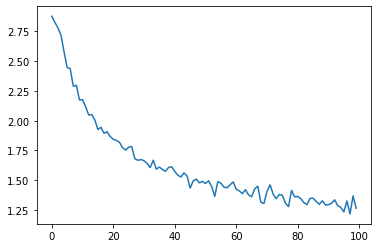

In [60]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Evaluating the Results

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop

In [0]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

In [0]:
# Just return an output given a line
def evaluate(line_tensor):
    rnn.eval()
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [0]:
# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

In [0]:
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

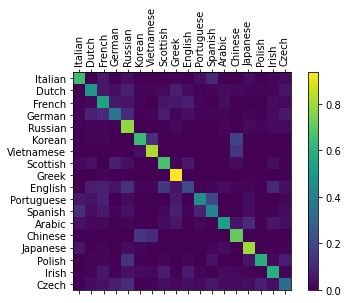

In [66]:
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [0]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


In [68]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.53) Russian
(-1.12) Czech
(-3.07) Polish

> Jackson
(-0.21) Scottish
(-2.32) English
(-2.67) Russian

> Satoshi
(-1.19) Italian
(-1.20) Japanese
(-3.04) Arabic
